In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import io
! pip install sentencepiece
# !apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
# !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
# !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
# !pip install mecab-python3 > /dev/null
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [0]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [0]:
data = read_text("/content/drive/My Drive/Colab Notebooks/raw.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [0]:
deu_eng = deu_eng[:30000,:]

In [7]:
deu_eng

array([["you are back, aren't you, harold?", 'あなたは戻ったのね ハロルド?'],
       ['my opponent is shark.', '俺の相手は シャークだ。'],
       ['this is one thing in exchange for another.', '引き換えだ ある事とある物の'],
       ...,
       ['now i see it.', '思い出したわ'],
       ["we weren't born to hate each other", '僕たちは憎しみ合う為に 生まれてきたンじゃない'],
       ["most people can't just wish them away with a wave of their hand.",
        '普通の人は 手を振って 検問所を消すことは 出来ないが・・・']], dtype='<U352')

In [8]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]
deu_eng

array([['you are back arent you harold', 'あなたは戻ったのね ハロルド'],
       ['my opponent is shark', '俺の相手は シャークだ。'],
       ['this is one thing in exchange for another', '引き換えだ ある事とある物の'],
       ...,
       ['now i see it', '思い出したわ'],
       ['we werent born to hate each other', '僕たちは憎しみ合う為に 生まれてきたンじゃない'],
       ['most people cant just wish them away with a wave of their hand',
        '普通の人は 手を振って 検問所を消すことは 出来ないが・・・']], dtype='<U352')

In [0]:
# sentencePiece
import sentencepiece as spm

sp = spm.SentencePieceProcessor()


In [15]:
# train SentencePieceTrainer model using english dataset
spm.SentencePieceTrainer.Train('--input=english.txt --model_prefix=m --hard_vocab_limit=false --vocab_size=30000')


True

In [16]:
# english sentencepiece
sp.Load('/content/drive/My Drive/wiki-ja.model')
deu_eng[:,0] = ["".join(sp.encode_as_pieces(i)).replace('▁', ' ') for i in deu_eng[:,0]]
# japanese sentencepiece
sp.Load('m.model')
deu_eng[:,1] = ["".join(sp.encode_as_pieces(i)).replace('▁', ' ') for i in deu_eng[:,1]]
deu_eng

array([[' you are back arent you harold', ' あなたは戻ったのね ハロルド'],
       [' my opponent is shark', ' 俺の相手は シャークだ。'],
       [' this is one thing in exchange for another', ' 引き換えだ ある事とある物の'],
       ...,
       [' now i see it', ' 思い出したわ'],
       [' we werent born to hate each other', ' 僕たちは憎しみ合う為に 生まれてきたンじゃない'],
       [' most people cant just wish them away with a wave of their hand',
        ' 普通の人は 手を振って 検問所を消すことは 出来ないが・・・']], dtype='<U352')

In [17]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([[' you are back arent you harold', ' あなたは戻ったのね ハロルド'],
       [' my opponent is shark', ' 俺の相手は シャークだ。'],
       [' this is one thing in exchange for another', ' 引き換えだ ある事とある物の'],
       ...,
       [' now i see it', ' 思い出したわ'],
       [' we werent born to hate each other', ' 僕たちは憎しみ合う為に 生まれてきたンじゃない'],
       [' most people cant just wish them away with a wave of their hand',
        ' 普通の人は 手を振って 検問所を消すことは 出来ないが・・・']], dtype='<U352')

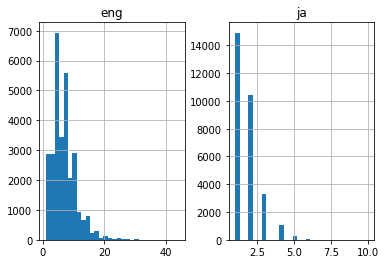

In [18]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'ja':deu_l})

length_df.hist(bins = 30)
plt.show()

In [19]:
print("max length English {}".format(max(eng_l)))
print("max length Japanese {}".format(max(deu_l)))

max length English 44
max length Japanese 10


In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [21]:
# prepare English tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 10
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 17121


In [22]:
# prepare Japanese tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 10
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 43473


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [0]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.3, random_state = 42)

In [0]:
# prepare training data
trainY = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testY = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    Dropout(rate=0.5)
    model.add(RepeatVector(out_timesteps))
    Dropout(rate=0.5)
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [27]:
# model compilation
model = define_model(eng_vocab_size, deu_vocab_size,eng_length, deu_length, 512)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:
rms = optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
filename = 'model.h1.22_Nov_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=20, batch_size=258, validation_split = 0.2, callbacks=[checkpoint],                    
                    verbose=1)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


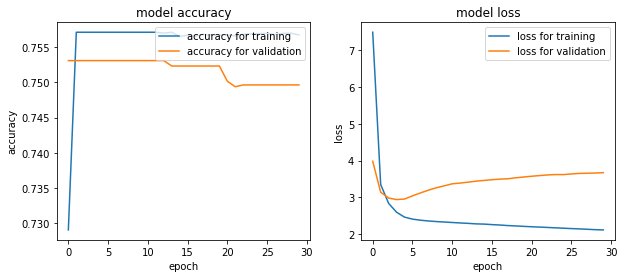

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
print(history.history.keys())
def plot_history_loss(history):
  ax1.plot(history.history['acc'],label="accuracy for training")
  ax1.plot(history.history['val_acc'],label="accuracy for validation")
  ax1.set_title('model accuracy')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('accuracy')
  ax1.legend(loc='upper right')

def plot_history_acc(history):
    # Plot the loss in the history
    ax2.plot(history.history['loss'],label="loss for training")
    ax2.plot(history.history['val_loss'],label="loss for validation")
    ax2.set_title('model loss')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(loc='upper right')

plot_history_loss(history)
plot_history_acc(history)

plt.show()

In [0]:
model = load_model('model.h1.22_Nov_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [0]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], deu_tokenizer)

            if j > 0:
                if (t == get_word(i[j-1], deu_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))


In [0]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [0]:
pred_df.sample(50)

,actual,predicted
2840,堀池 清美の ロスタイムが 終わりました。,
2455,その時進入できる。,
2683,背後から 彼女を襲ったのか,
1515,よくやった,
159,教会の犬め,
2005,馴れたもんだろ,
2403,おおきになぁ。 あっ いえいえ。,
633,何だよ それ 子供は親の所有物じゃないのに,
1918,ばかげてます,
566,不安を感じながらも どうにかやり遂げたというような感じです,
